In [122]:
from scipy import signal
from scipy.fft import rfft, rfftfreq

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import re
import os
import tsfresh

D:\Anaconda\envs\Lateraldispl\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
D:\Anaconda\envs\Lateraldispl\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [84]:
def load_gm(path):
    with open(path) as f:
        contents = f.readlines()

    num_point = int(re.split(r'\s+|,',contents[3])[1])
    DT = float(re.split(r'\s+|,',contents[3])[4])
    gm = ''.join(contents[4:])
    gm = np.array(gm.split()).astype(float)
    
    #some of DTs are 0.002
    if DT != 0.005:
        t = np.arange(num_point)*DT
        t0005 = np.arange(0, t.max()+0.005, 0.005)
        gm = np.interp(t0005, t, gm)
    
    #padding 0 to ground motion
    if len(gm) < 30000:
        gm = np.pad(gm, (0,30000-len(gm)))

    return gm

In [95]:
# loading all .AT2 profiles.
acc = []
RSNID = []
DIR = []
EVENT = []
for event in ["Christchurch/", "Darfield/"]:
    print(event)
    for root, dirs, files in os.walk(event):
        for file in tqdm(files):
            if file.endswith(".AT2"):
                RSNID.append(file[:-4].split('_')[0])
                EVENT.append(file[:-4].split('_')[1])
                DIR.append(file[:-4].split('_')[2])
                acc.append(load_gm(os.path.join(root, file)))

Christchurch/


  0%|          | 0/910 [00:00<?, ?it/s]

Darfield/


  0%|          | 0/910 [00:00<?, ?it/s]

In [118]:
df_gm = pd.DataFrame(data=np.array(acc), columns=np.arange(0,150,0.005).astype(str))
df_gm.insert(0, "EVENT", EVENT)
df_gm.insert(1, "RSNID", RSNID)
df_gm.insert(2, "DIR", DIR)

In [119]:
# seperate horizotal and vertical ground motions
df_gm_v = df_gm[df_gm['DIR'].str.contains('UP')]
df_gm_h = df_gm[~df_gm['DIR'].str.contains('UP')]
df_gm_h.head()

In [304]:
df_gm_h.to_csv('gm_h.csv', index=False)

# PCA

In [107]:
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sns

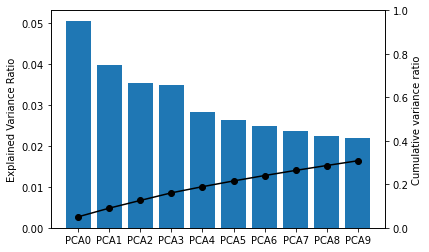

In [121]:
n_components=10
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=n_components))])
# drop nan rows
pipeline.fit(df_gm_h.iloc[:,3:])

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.bar(x=np.arange(n_components),
        height=pipeline['pca'].explained_variance_ratio_,
        tick_label=pca_number)
ax1.set_ylabel('Explained Variance Ratio')

ax2.plot(np.arange(n_components), np.cumsum(pipeline['pca'].explained_variance_ratio_), 'ko-')
ax2.set_ylabel('Cumulative variance ratio')
ax2.set_ylim(0,1)
plt.show()

# Short-Time Fourier transform

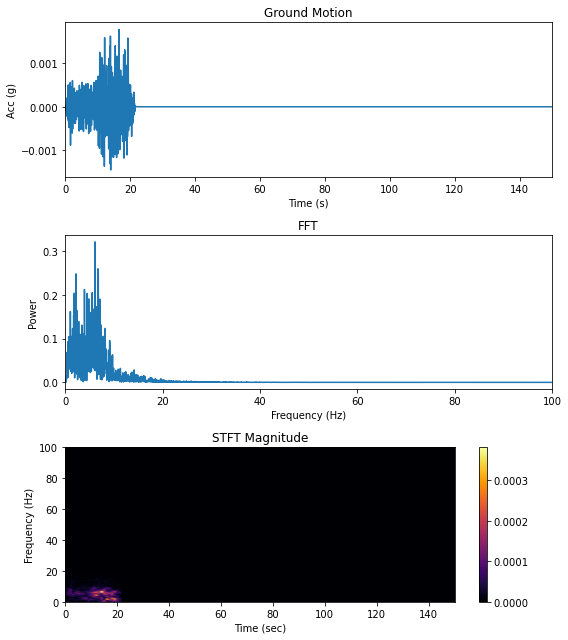

In [308]:
num = 10
x = df_gm_h.iloc[num, 3:].values.astype(float)
fs = 1/0.005
f, t, Zxx = signal.stft(x, fs, nperseg=400)

fig, axes = plt.subplots(3,1, figsize=(8,9))

axes[0].plot(np.linspace(0,150,num=30000,endpoint=False), x)
axes[0].set_title('Ground Motion')
axes[0].set_ylabel('Acc (g)')
axes[0].set_xlabel('Time (s)')
axes[0].set_xlim(0,150)

# Number of samples in normalized_tone
N = 30000
yf = rfft(x)
xf = rfftfreq(N, 1 / 200)
axes[1].plot(xf, np.abs(yf))
axes[1].set_title('FFT')
axes[1].set_ylabel('Power')
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_xlim(0,100)

cmap = plt.colormaps['inferno']
im = axes[2].pcolormesh(t, f, np.abs(Zxx), vmin=0, shading='gouraud', cmap=cmap)
axes[2].set_title('STFT Magnitude')
axes[2].set_ylabel('Frequency (Hz)')
axes[2].set_xlabel('Time (sec)')
fig.colorbar(im, ax=axes[2])

plt.tight_layout()
plt.show()

In [273]:
Zxx.shape

(201, 151)

In [307]:
STFT[-1].reshape(201,151)

array([[1.19604134e-06, 3.34751123e-06, 1.43383949e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.15555731e-07, 1.17801421e-05, 2.53754761e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.13180670e-07, 8.53742747e-06, 3.59851893e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.46474714e-09, 7.39704254e-12, 1.24884116e-10, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.46771193e-09, 6.09238942e-12, 1.02569131e-10, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.46838848e-09, 3.72892514e-13, 8.81416549e-11, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [281]:
STFT = []
fs = 1/0.005
for i in trange(len(df_gm_h)):
    x = df_gm_h.iloc[i, 3:].values.astype(float)
    f, t, Zxx = signal.stft(x, fs, nperseg=400)
    STFT.append(abs(Zxx).reshape(-1))

  0%|          | 0/404 [00:00<?, ?it/s]

In [296]:
df_stft = pd.DataFrame(data=STFT)
df_stft.insert(0, "EVENT", df_gm_h['EVENT'].values)
df_stft.insert(1, "RSNID", df_gm_h['RSNID'].values)
df_stft.insert(2, "DIR", df_gm_h['DIR'].values)
df_stft.head()

,EVENT,RSNID,DIR,0,1,2,3,4,5,6,...,30341,30342,30343,30344,30345,30346,30347,30348,30349,30350
0,CCHURCH,RSN8056,ADCSN42W,0.000002,0.000002,0.000010,0.000010,0.000048,3.745079e-05,2.535306e-07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CCHURCH,RSN8056,ADCSN48E,0.000005,0.000023,0.000085,0.000008,0.000044,5.071303e-05,8.420631e-05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CCHURCH,RSN8057,AMBCN86E,0.000007,0.000009,0.000003,0.000015,0.000033,4.407218e-05,9.834199e-05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CCHURCH,RSN8057,AMBCS04E,0.000008,0.000013,0.000002,0.000036,0.000156,1.320123e-04,1.742514e-05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CCHURCH,RSN8058,APPSN09W,0.000002,0.000003,0.000002,0.000001,0.000001,3.744235e-07,4.172051e-07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [303]:
df_stft.to_csv('stft.csv', index=False)

# TSFRESH

In [8]:
extracted_features = tsfresh.extract_features(df, column_id='id', column_sort='time', n_jobs=0)
#extracted_features = tsfresh.extract_features(df, column_id='id', column_sort='time', default_fc_parameters=tsfresh.feature_extraction.EfficientFCParameters())

Feature Extraction: 100%|██████████| 3/3 [18:01<00:00, 360.54s/it]


In [21]:
for feature in extracted_features.columns[:787]:
    print(feature)

a__variance_larger_than_standard_deviation
a__has_duplicate_max
a__has_duplicate_min
a__has_duplicate
a__sum_values
a__abs_energy
a__mean_abs_change
a__mean_change
a__mean_second_derivative_central
a__median
a__mean
a__length
a__standard_deviation
a__variation_coefficient
a__variance
a__skewness
a__kurtosis
a__root_mean_square
a__absolute_sum_of_changes
a__longest_strike_below_mean
a__longest_strike_above_mean
a__count_above_mean
a__count_below_mean
a__last_location_of_maximum
a__first_location_of_maximum
a__last_location_of_minimum
a__first_location_of_minimum
a__percentage_of_reoccurring_values_to_all_values
a__percentage_of_reoccurring_datapoints_to_all_datapoints
a__sum_of_reoccurring_values
a__sum_of_reoccurring_data_points
a__ratio_value_number_to_time_series_length
a__sample_entropy
a__maximum
a__minimum
a__benford_correlation
a__time_reversal_asymmetry_statistic__lag_1
a__time_reversal_asymmetry_statistic__lag_2
a__time_reversal_asymmetry_statistic__lag_3
a__c3__lag_1
a__c3__la

In [49]:
extracted_features.columns

Index(['a__variance_larger_than_standard_deviation', 'a__has_duplicate_max',
       'a__has_duplicate_min', 'a__has_duplicate', 'a__sum_values',
       'a__abs_energy', 'a__mean_abs_change', 'a__mean_change',
       'a__mean_second_derivative_central', 'a__median',
       ...
       'd__permutation_entropy__dimension_5__tau_1',
       'd__permutation_entropy__dimension_6__tau_1',
       'd__permutation_entropy__dimension_7__tau_1',
       'd__query_similarity_count__query_None__threshold_0.0',
       'd__matrix_profile__feature_"min"__threshold_0.98',
       'd__matrix_profile__feature_"max"__threshold_0.98',
       'd__matrix_profile__feature_"mean"__threshold_0.98',
       'd__matrix_profile__feature_"median"__threshold_0.98',
       'd__matrix_profile__feature_"25"__threshold_0.98',
       'd__matrix_profile__feature_"75"__threshold_0.98'],
      dtype='object', length=2361)